**<h1><center>Exploratory Data Analysis (EDA) On Amazon Review Data (2018)</center></h1>**

Exploratory Data Analysis (EDA) is an approach to analysing data in order to summarise its main characteristics and identify patterns or relationships between variables. It is typically used as a preliminary step in the data analysis process, before more formal statistical methods are applied. The goal of Exploratory Data Analysis (EDA) is to gain a better understanding of the data and to generate insights that can guide further analysis.

In the context of product reviews, Exploratory Data Analysis (EDA) can be used to examine various aspects of the reviews, such as the number of reviews per product, the distribution of ratings, the frequency of certain keywords or phrases in the reviews, and the relationship between the length of the review and the rating. It can also be used to inform further analysis and modelling of the data, as well as to identify potential data quality issues that may need to be addressed.

## What Is Our Approach?

For our analysis of the Amazon Review Data (2018) dataset, we utilise inferential statistical analysis as a key component of our approach to Exploratory Data Analysis (EDA). Inferential statistical analysis involves analysing a sample of data to make predictions or draw conclusions about a larger population from which the sample was drawn. Given the large size of the dataset, our goal is to use a sample of the data to make predictions or draw inferences about the larger population with a certain degree of confidence or probability.

### What Problem Does Our Approach Aim to Alleviate?

Amazon Review Data (2018) is an extensive dataset, comprising almost 233.1 million records, and requiring around 60 gigabytes (GB) of data storage. Due to its size, the dataset demands a considerable amount of computation that ordinary computers cannot handle easily. To overcome this challenge, we adopt an inferential statistical analysis approach, which enables us to draw accurate conclusions about the entire population using only a sample of the data. By estimating the parameters of the population with a certain degree of confidence or probability, we can reduce the computational overhead significantly. However, it is crucial to carefully consider the assumptions and limitations of the statistical models and methods employed to ensure reliable and precise results.

### What Sampling Technique Did We Use?

Given the wide range of products and reviews covered in the dataset, there is an inherent imbalance between attributes. To address this issue, we utilised stratified random sampling to extract a sample of 100,000 records from the population while ensuring that the ratio of products in the dataset is maintained. **(sample.py, 1-52)** Stratified random sampling involves dividing the population into subgroups or strata based on specific characteristics and then selecting a random sample from each stratum in proportion to its size or importance within the population. The resulting samples from each stratum are then combined to form the overall sample, resulting in a more representative and accurate sample for analysis.

The advantage of stratified random sampling over random sampling is that it ensures that each stratum is well-represented in the sample, which can improve the accuracy and precision of the estimates. This is particularly important when there are significant differences or variations within the population, as it allows for more accurate estimates of the characteristics of each subgroup.

In [1]:
#   Importing the necessary libraries/modules.

from pyspark.sql import SparkSession
import pandas as pd
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from wordcloud import WordCloud
from nltk.corpus import stopwords
import warnings

In [2]:
warnings.filterwarnings("ignore")   #   Ignoring any warnings.

#### Reading the Required Data:

To begin with, we intend to establish a **SparkSession** instance for establishing a connection to MongoDB using the MongoDB Connector for Spark. Subsequently, we will extract the data stored in the **product_reviews** collection of the **amazon_review_data** database in MongoDB. This Spark DataFrame will solely facilitate the calculation and retrieval of basic statistical information pertaining to the dataset, as any sophisticated data processing tasks necessitate substantial computational power.

In [3]:
#   Creating an instance of a SparkSession object and connecting it to MongoDB.

spark=SparkSession \
    .builder \
    .appName("ExploratoryDataAnalysis") \
    .master("local") \
    .config("spark.mongodb.input.uri", "mongodb://localhost:27017/") \
    .config("spark.mongodb.output.uri", "mongodb://localhost:27017/") \
    .config("spark.executor.memory", "8g") \
    .config("spark.driver.memory", "8g") \
    .config("spark.jars.packages", "org.mongodb.spark:mongo-spark-connector_2.12:3.0.1") \
    .getOrCreate()

spark.sparkContext.setLogLevel("ERROR") #   Overriding the default log level.

#   Reading the dataset from the MongoDB database as a collection into the Spark DataFrame.

database=spark.read.format("com.mongodb.spark.sql.DefaultSource") \
    .option("uri", "mongodb://localhost:27017/amazon_review_data.product_reviews") \
    .option("partitioner", "MongoSinglePartitioner") \
    .option("partitionKey", "asin") \
    .load()

23/04/25 17:16:31 WARN Utils: Your hostname, Huzaifas-MacBook-Pro-2.local resolves to a loopback address: 127.0.0.1; using 192.168.100.13 instead (on interface en0)
23/04/25 17:16:31 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Ivy Default Cache set to: /Users/huzaifa/.ivy2/cache
The jars for the packages stored in: /Users/huzaifa/.ivy2/jars
org.mongodb.spark#mongo-spark-connector_2.12 added as a dependency
:: resolving dependencies :: org.apache.spark#spark-submit-parent-adbb9d46-5401-433f-8ece-04655c003bb0;1.0
	confs: [default]


:: loading settings :: url = jar:file:/Users/huzaifa/Library/Python/3.9/lib/python/site-packages/pyspark/jars/ivy-2.5.1.jar!/org/apache/ivy/core/settings/ivysettings.xml


	found org.mongodb.spark#mongo-spark-connector_2.12;3.0.1 in central
	found org.mongodb#mongodb-driver-sync;4.0.5 in central
	found org.mongodb#bson;4.0.5 in central
	found org.mongodb#mongodb-driver-core;4.0.5 in central
:: resolution report :: resolve 106ms :: artifacts dl 4ms
	:: modules in use:
	org.mongodb#bson;4.0.5 from central in [default]
	org.mongodb#mongodb-driver-core;4.0.5 from central in [default]
	org.mongodb#mongodb-driver-sync;4.0.5 from central in [default]
	org.mongodb.spark#mongo-spark-connector_2.12;3.0.1 from central in [default]
	---------------------------------------------------------------------
	|                  |            modules            ||   artifacts   |
	|       conf       | number| search|dwnlded|evicted|| number|dwnlded|
	---------------------------------------------------------------------
	|      default     |   4   |   0   |   0   |   0   ||   4   |   0   |
	---------------------------------------------------------------------
:: retrieving ::

#### Validating the Population and Sample Distribution:

Inferential statistics is dependent on balanced samples that are representative of the population being studied. Therefore, it is crucial to examine whether the distribution of both the sample and population adhere to a normal distribution. Considering that we employed stratified random sampling to sample the population for our inferential statistical analysis, we assumed that the sample accurately reflects the population. Hence, both the distributions of the sample and population should be comparable, if not identical.

To accomplish this, we will initially group the population data by the target variable, which pertains to the product review ratings that vary between zero and five. Subsequently, we will perform aggregation on this data to obtain the total count of each interval encompassing the range of potential ratings that customers may award.

In [4]:
population_ratings=database.groupBy("overall").count().toPandas()   #   Aggregating the number of ratings for each rating value and converting to a pandas.DataFrame.
population_ratings

,overall,count
0,0.0,7
1,1.0,13530429
2,4.0,32347333
3,3.0,14911023
4,2.0,8730123
5,5.0,130945372


Having acquired a basic comprehension of the dataset's attributes, we can now proceed with our inferential statistical analysis. Our first step would be to import the sample that we had extracted from the population through stratified random sampling.

In [5]:
dataframe=pd.read_csv("./data/sample.csv")  #   Reading the sample data from the comma-separated values (CSV) file into a pandas.DataFrame.
dataframe=dataframe.drop(dataframe.columns[0], axis=1)  #   Dropping the first column of the pandas.DataFrame.
dataframe

,asin,image,overall,reviewText,reviewerID,reviewerName,style,summary,unixReviewTime,verified
0,B0153XNDL6,NaN,5.0,Found out after purchasing that I didn't need ...,AY4TNCPU7VF2V,L. Becker,"Row(Capacity:=None, Color Name:=None, Color:='...",Five Stars,1483315200,True
1,B0009WG6O8,NaN,5.0,"Well, when I first got the product, I thought ...",A3DXKAYP87HZBC,Joseph R. Bravo,"Row(Capacity:=None, Color Name:=None, Color:=N...",Parallel clothes dryer,1215993600,False
2,B00JZRLL9S,NaN,5.0,Bought it for my boyfriend. Slim wallet and fi...,A33KCG4PDDQ9K4,Amazon Customer,"Row(Capacity:=None, Color Name:=None, Color:='...",Holds all his cards and cash comfortably.,1464652800,True
3,B01BGFQQPK,NaN,3.0,Runs big. Looks kind of like a tent. The purpl...,A3652VGRAPVC1L,Kara Jade,"Row(Capacity:=None, Color Name:=None, Color:='...",Large tent that's too short!!!!,1463529600,True
4,B004B93RC4,NaN,1.0,Didn't appreciate the foul language...so I tur...,A1Z7SBOMPV24BG,E.M.,"Row(Capacity:=None, Color Name:=None, Color:=N...","Started off funny, but then.....",1405382400,False
...,...,...,...,...,...,...,...,...,...,...
99995,B00LHEQFXO,NaN,1.0,Tiara looked great in the package. But once my...,A30N5M2Z313SYT,Coreena R Parras,NaN,Tiara looked great in the package,1421712000,True
99996,B002IESE9U,NaN,5.0,"great but price has gone up, not happy about that",A2ZP1OVFN8ZKX2,DXTR 45,NaN,Five Stars,1521072000,True
99997,B005255P5I,NaN,5.0,Seagate is a good manufacturer of hd's. I am a...,A26D3IDG30WQIE,Craig,"Row(Capacity:=None, Color Name:=None, Color:=N...",Five Stars,1497916800,True
99998,B00LAD85FS,NaN,5.0,I think this is a great idea. But I wasn't abl...,A3150PU6FNST3W,Angela Rentch,NaN,I think this is a great idea. But I wasn't abl...,1511740800,True


As previously mentioned, before proceeding with our inferential statistical analysis, we must confirm whether the distribution of both the sample and population conforms to a normal distribution. If this criterion is not satisfied, it may not be feasible to obtain accurate estimations through statistical inference. To accomplish this, we will once again aggregate the data to obtain the total count of each interval that includes the range of potential ratings that customers may assign.

In [6]:
sample_ratings=dataframe.groupby("overall", sort=False).count() #   Aggregating the number of ratings for each rating value.
sample_ratings=sample_ratings.iloc[:, 0:1]  #   Selecting the first column of the pandas.DataFrame.
sample_ratings.columns=["count"]    #   Renaming the column of the pandas.DataFrame.
sample_ratings=sample_ratings.reset_index() #   Resetting the index of the pandas.DataFrame.
sample_ratings

,overall,count
0,5.0,65471
1,3.0,7565
2,1.0,6622
3,4.0,15919
4,2.0,4423


The objective behind aggregating both the population and sample data over the total count of each interval in the range of potential ratings is to verify the ratio of the sample to the population. We anticipate this ratio to be comparable, if not identical, indicating that our sample is a precise or identical representation of the population. This is crucial to validate before drawing any inferences.

To accomplish this, we will create a visual representation of the distribution of both the population and sample data to ensure that they are comparable and adhere to a normal distribution.

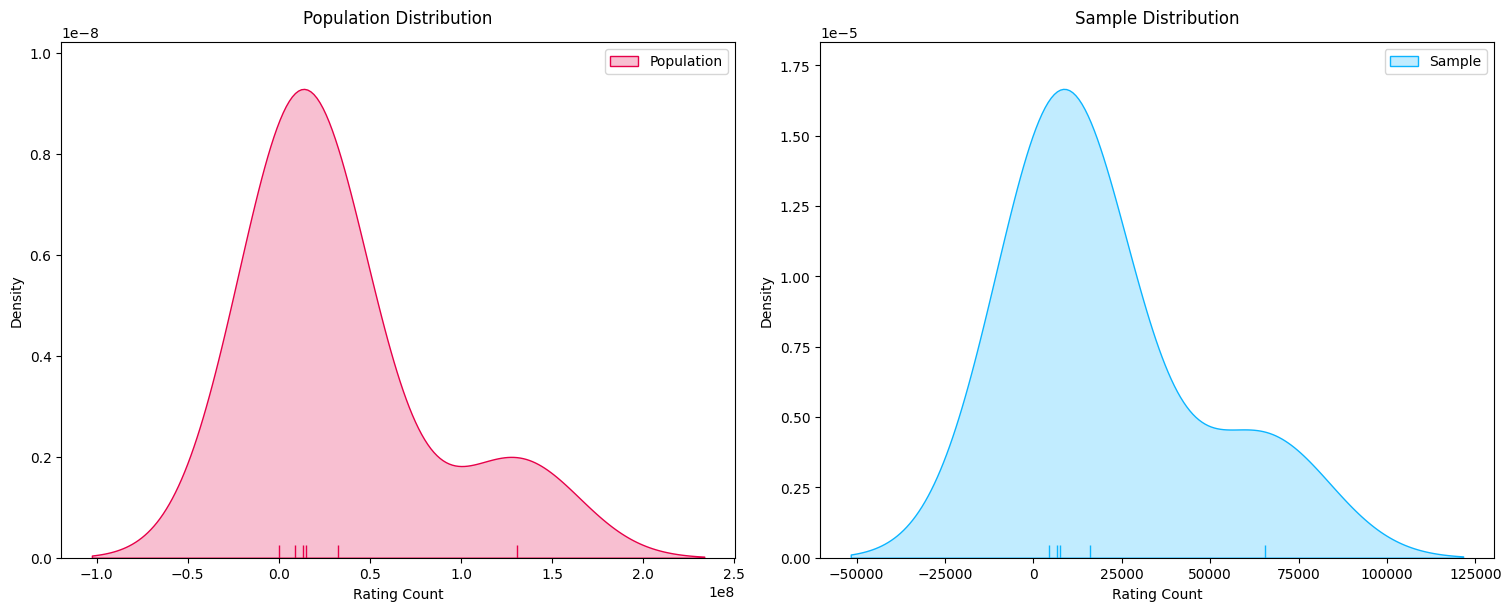

In [7]:
#   Creating a sub-plot of the population and sample distributions of the rating counts.

figure, axis=plt.subplots(ncols=2, figsize=(15, 6), constrained_layout=True)

#   Plotting a distribution plot of the population and sample distributions of the rating counts.

sns.distplot(population_ratings["count"], color="#E60049", label="Population", hist=False, kde_kws={"shade": True}, axlabel="Rating Count", rug=True, ax=axis[0])
axis[0].set_title("Population Distribution", y=1.02)
sns.distplot(sample_ratings["count"], color="#0BB4FF", label="Sample", hist=False, kde_kws={"shade": True}, axlabel="Rating Count", rug=True, ax=axis[1])
axis[1].set_title("Sample Distribution", y=1.02)
axis[0].legend(loc="upper right")
axis[1].legend(loc="upper right")
plt.show()

As observed in this instance, the sample data closely resembles the population data, which indicates that any inferences we draw from the sample can be confidently extrapolated to the population in our inferential statistical analysis.

#### Preliminary Data Cleaning:

In [8]:
dataframe.dtypes    #   Displaying the data types of the columns of the pandas.DataFrame.

asin               object
image              object
overall           float64
reviewText         object
reviewerID         object
reviewerName       object
style              object
summary            object
unixReviewTime      int64
verified             bool
dtype: object

Prior to conducting any analysis, it is crucial to ensure that the dataset is cleaned. In our situation, the data is semi-structured as it has been extracted from a NoSQL database. The **style** column presents unstructured information, with each value representing a distinct attribute of a given product (**asin**). Moreover, there are missing values in the **image** column that must be managed appropriately. Therefore, preliminary data cleaning is necessary before proceeding with our Exploratory Data Analysis (EDA).

Our approach involves transforming the unstructured information in the **style** column into individual columns that represent the corresponding attributes. Since the dataset comprises products from various categories, in instances where a product lacks a particular attribute, we substitute it with "None". Similarly, for missing values in the **image** column, we replace them with "None" to indicate the absence of images in the product reviews. Furthermore, we need to convert the values in the **unixReviewTime** column from unix timestamp format to datetime format to facilitate further analysis.

In [9]:
new_columns=dataframe["style"].str.split(", ", expand=True) #   Splitting the column into multiple columns in the pandas.DataFrame.
new_columns=new_columns.apply(lambda x: x.str.split(":="))  #   Splitting the values of the columns in the pandas.DataFrame.
new_columns=new_columns.fillna("")  #   Filling the missing values in the pandas.DataFrame.
column_dictionary={}

#   Iterating through the columns in the pandas.DataFrame.

for column in new_columns.columns:
    split_values=new_columns.iloc[0, column]    #   Extracting the first value of the column in the pandas.DataFrame.
    if split_values:    #   Condition to check whether the column is empty or not.
        column_name=split_values[0] #   Extracting the first value of the column in the pandas.DataFrame.
        column_value=split_values[1]    #   Extracting the second value of the column in the pandas.DataFrame.
        column_dictionary[column_name]=new_columns.iloc[:, column].str[-1]  #   Extracting the last value of the column in the pandas.DataFrame.

dataframe=pd.concat([dataframe.drop("style", axis=1), pd.DataFrame(column_dictionary)], axis=1) #   Concatenating the new columns to the pandas.DataFrame.
dataframe=dataframe.drop("Row(Capacity", axis=1)    #   Dropping the column from the pandas.DataFrame.
dataframe.iloc[:, 8:]=dataframe.iloc[:, 8:].fillna("None")  #   Filling the missing values of the columns in the pandas.DataFrame.
dataframe.iloc[:, 8:]=dataframe.iloc[:, 8:].astype(str) #   Converting the columns in the pandas.DataFrame to string format.
dataframe.iloc[:, 8:]=dataframe.iloc[:, 8:].applymap(lambda x: x.replace("'", '') if isinstance(x, str) else x) #   Removing the single quotes from the columns in the pandas.DataFrame.
dataframe["Width"]=dataframe["Width"].apply(lambda x: x.replace(")", '') if isinstance(x, str) else x)  #   Removing the closing brackets from the column in the pandas.DataFrame.
dataframe["image"]=dataframe["image"].fillna("None")    #   Filling the missing values of the column in the pandas.DataFrame.
dataframe["unixReviewTime"]=pd.to_datetime(dataframe["unixReviewTime"], unit="s")   #   Converting the column in the pandas.DataFrame to datetime format.
dataframe["unixReviewTime"]=dataframe["unixReviewTime"].dt.strftime("%Y-%m-%d %H:%M:%S")    #   Converting the column in the pandas.DataFrame to string format.
dataframe=dataframe.rename(columns={"unixReviewTime": "reviewTime"})    #   Renaming the column in the pandas.DataFrame.
dataframe

,asin,image,overall,reviewText,reviewerID,reviewerName,summary,reviewTime,verified,Color Name,...,Package Type,Pattern,Platform,Product Packaging,Size Name,Size,Style Name,Style,Team Name,Width
0,B0153XNDL6,None,5.0,Found out after purchasing that I didn't need ...,AY4TNCPU7VF2V,L. Becker,Five Stars,2017-01-02 00:00:00,True,None,...,None,None,None,None,None,2,None,None,None,None
1,B0009WG6O8,None,5.0,"Well, when I first got the product, I thought ...",A3DXKAYP87HZBC,Joseph R. Bravo,Parallel clothes dryer,2008-07-14 00:00:00,False,None,...,None,None,None,None,Deluxe Parallel,None,None,None,None,None
2,B00JZRLL9S,None,5.0,Bought it for my boyfriend. Slim wallet and fi...,A33KCG4PDDQ9K4,Amazon Customer,Holds all his cards and cash comfortably.,2016-05-31 00:00:00,True,None,...,None,None,None,None,None,None,None,None,None,None
3,B01BGFQQPK,None,3.0,Runs big. Looks kind of like a tent. The purpl...,A3652VGRAPVC1L,Kara Jade,Large tent that's too short!!!!,2016-05-18 00:00:00,True,None,...,None,None,None,None,None,X-Large,None,None,None,None
4,B004B93RC4,None,1.0,Didn't appreciate the foul language...so I tur...,A1Z7SBOMPV24BG,E.M.,"Started off funny, but then.....",2014-07-15 00:00:00,False,None,...,None,None,None,None,None,None,None,None,None,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99995,B00LHEQFXO,None,1.0,Tiara looked great in the package. But once my...,A30N5M2Z313SYT,Coreena R Parras,Tiara looked great in the package,2015-01-20 00:00:00,True,None,...,None,None,None,None,None,None,None,None,None,None
99996,B002IESE9U,None,5.0,"great but price has gone up, not happy about that",A2ZP1OVFN8ZKX2,DXTR 45,Five Stars,2018-03-15 00:00:00,True,None,...,None,None,None,None,None,None,None,None,None,None
99997,B005255P5I,None,5.0,Seagate is a good manufacturer of hd's. I am a...,A26D3IDG30WQIE,Craig,Five Stars,2017-06-20 00:00:00,True,None,...,None,None,None,None,None,2 TB,None,None,None,None
99998,B00LAD85FS,None,5.0,I think this is a great idea. But I wasn't abl...,A3150PU6FNST3W,Angela Rentch,I think this is a great idea. But I wasn't abl...,2017-11-27 00:00:00,True,None,...,None,None,None,None,None,None,None,None,None,None


In [10]:
dataframe.isnull().sum()    #   Checking for missing values in the pandas.DataFrame.

asin                         0
image                        0
overall                      0
reviewText                  70
reviewerID                   0
reviewerName                 7
summary                     35
reviewTime                   0
verified                     0
Color Name                   0
Color                        0
Connectivity                 0
Digital Storage Capacity     0
Flavor Name                  0
Flavor                       0
Format                       0
Length                       0
Metal Type                   0
Number of Items              0
Offer Type                   0
Package Quantity             0
Package Type                 0
Pattern                      0
Platform                     0
Product Packaging            0
Size Name                    0
Size                         0
Style Name                   0
Style                        0
Team Name                    0
Width                        0
dtype: int64

The dataset also contains a small percentage of missing values in the **reviewText** and **summary** columns. Given that the missing values represent less than 5% of the total dataset, we can safely remove them without affecting the validity of our analysis.

In [11]:
dataframe=dataframe.dropna()    #   Dropping the missing values in the pandas.DataFrame.
dataframe.isnull().sum()    #   Checking for missing values in the pandas.DataFrame.

asin                        0
image                       0
overall                     0
reviewText                  0
reviewerID                  0
reviewerName                0
summary                     0
reviewTime                  0
verified                    0
Color Name                  0
Color                       0
Connectivity                0
Digital Storage Capacity    0
Flavor Name                 0
Flavor                      0
Format                      0
Length                      0
Metal Type                  0
Number of Items             0
Offer Type                  0
Package Quantity            0
Package Type                0
Pattern                     0
Platform                    0
Product Packaging           0
Size Name                   0
Size                        0
Style Name                  0
Style                       0
Team Name                   0
Width                       0
dtype: int64

## Exploratory Data Analysis (EDA):

#### Generating Summary Statistics:

To initiate our Exploratory Data Analysis (EDA), it is imperative to gather some summary statistics to comprehend the distribution of the data. Specifically, we will begin by exploring the distribution of the product ratings, which happens to be our key variable of interest in this analysis.

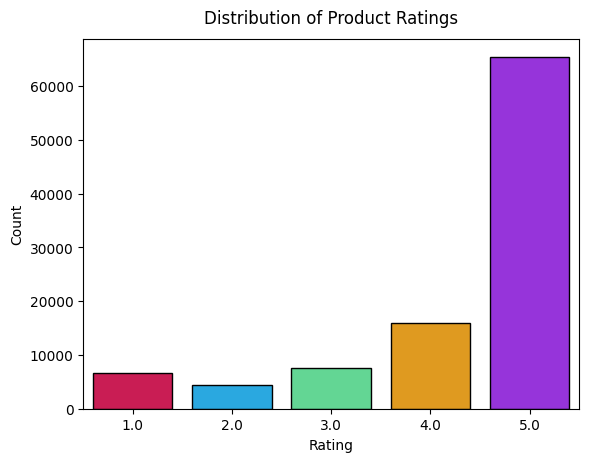

In [12]:
#   Plotting a bar plot of the distribution of the product ratings.

sns.barplot(x="overall", y="count", data=sample_ratings, palette=["#E60049", "#0BB4FF", "#50E991", "#FFA300", "#9B19F5"], edgecolor="black")
plt.title("Distribution of Product Ratings", y=1.02)
plt.xlabel("Rating")
plt.ylabel("Count")
plt.show()

The analysis indicates that a substantial proportion of reviews, almost 65%, have been assigned the highest rating of 5.0. This implies that the vast majority of customers who have reviewed the products are exceedingly satisfied with their purchase. Nevertheless, the increasing prevalence of fake reviews on online platforms is a growing concern, which can introduce biases in favour of certain products. Such spam reviews not only deceive customers but also potentially harm their purchase decisions based on the reviews.

##### **• Is there evidence to suggest that the product reviews rated as 5.0 are genuine customer feedback or are they possibly fake reviews generated by automated bots?**

Statistically, the majority of consumers worldwide are strongly opposed to censorship, with 70% expressing serious concerns regarding the censorship of customer reviews. Furthermore, 62% of global consumers have stated that they would discontinue using platforms that engage in review censorship, whether it's for fraudulent reviews or not. This is because consumers view review manipulation as a violation of trust and are willing to shift their patronage to other platforms if they discover that a company allows businesses to selectively showcase their reviews. **(Trustpilot, 2020)**

In order to determine whether the dataset provides evidence of fraudulent reviews, we will undertake several analyses, which will include:

- **Examining the review text:** If the review text is overly brief or generic, it may indicate that the review is fake. Moreover, if the review text closely resembles other reviews for the same product, this could be a warning sign.

- **Assessing the review timing:** If a large number of reviews were published at the same time, it could indicate that they were all authored by bots or fraudulent reviewers.

- **Scrutinising the review verification status:** If the majority of reviews are unverified, this could also be a potential red flag.

Prior to conducting the analyses, we will filter out all the product reviews that have been rated 5.0.

In [13]:
five_star_reviews=dataframe[dataframe["overall"]==5.0]  #   Selecting the reviews with five-star ratings.
five_star_reviews.head()

,asin,image,overall,reviewText,reviewerID,reviewerName,summary,reviewTime,verified,Color Name,...,Package Type,Pattern,Platform,Product Packaging,Size Name,Size,Style Name,Style,Team Name,Width
0,B0153XNDL6,None,5.0,Found out after purchasing that I didn't need ...,AY4TNCPU7VF2V,L. Becker,Five Stars,2017-01-02 00:00:00,True,None,...,None,None,None,None,None,2,None,None,None,None
1,B0009WG6O8,None,5.0,"Well, when I first got the product, I thought ...",A3DXKAYP87HZBC,Joseph R. Bravo,Parallel clothes dryer,2008-07-14 00:00:00,False,None,...,None,None,None,None,Deluxe Parallel,None,None,None,None,None
2,B00JZRLL9S,None,5.0,Bought it for my boyfriend. Slim wallet and fi...,A33KCG4PDDQ9K4,Amazon Customer,Holds all his cards and cash comfortably.,2016-05-31 00:00:00,True,None,...,None,None,None,None,None,None,None,None,None,None
6,B010FDT854,None,5.0,Best case I have ever had for my iphone for th...,A1Y6EWZH83X7GE,dylan drummer,Five Stars,2016-04-06 00:00:00,True,None,...,None,None,None,None,None,None,None,None,None,None
7,B01FIVVPZO,None,5.0,"Awesome, Brought Life to my showcases again",A20VBAYY9ZH5AS,Daniel,Awesome A++++,2017-08-12 00:00:00,True,None,...,None,None,None,None,None,None,None,Showcase LED,None,None


In [14]:
print("Maximum Length of 5.0 Rated Reviews:", five_star_reviews["reviewText"].str.len().max())
print("Minimum Length of 5.0 Rated Reviews:", five_star_reviews["reviewText"].str.len().min())
print("Average Length of 5.0 Rated Reviews:", five_star_reviews["reviewText"].str.len().mean())

Maximum Length of 5.0 Rated Reviews: 12772
Minimum Length of 5.0 Rated Reviews: 1
Average Length of 5.0 Rated Reviews: 184.51535402966815


Upon reviewing the summary statistics of the product reviews rated 5.0, we observe that the average review length is approximately 186 words. Notably, the maximum review length exceeds 12,000 words, which considerably overshadows the average. Conversely, the minimum review length is a single word, indicating substantial variability in the length of concise or generic reviews compared to the average length.

While these findings offer some insight into the nature of the product reviews, it is important to note that they do not conclusively determine whether the reviews are authentic customer feedback. Therefore, we must also examine the distribution of the reviews to gauge their density in the data, thereby enabling us to conduct a more thorough analysis of these reviews.

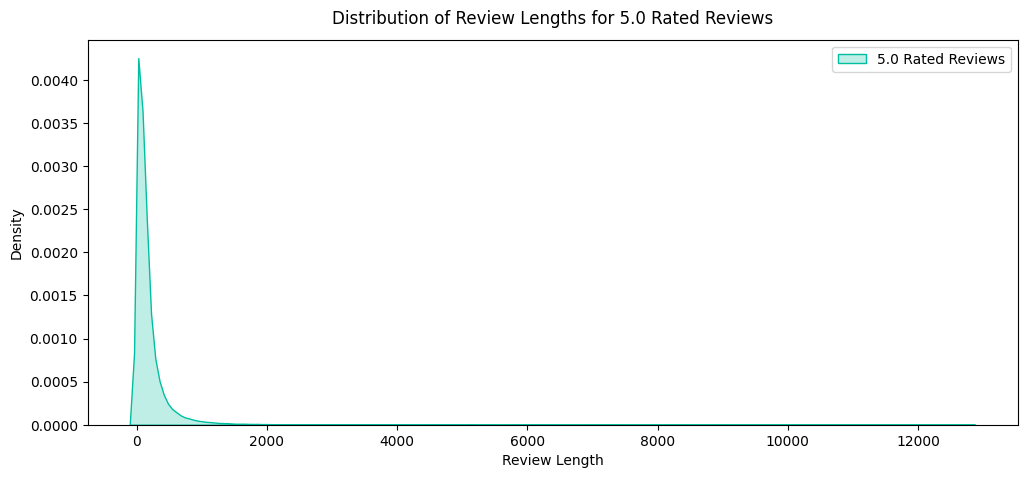

In [15]:
#   Plotting a distribution plot of the review lengths for the five-star rated reviews.

plt.figure(figsize=(12, 5))
sns.distplot(five_star_reviews["reviewText"].str.len(), color="#00BFA0", label="5.0 Rated Reviews", hist=False, kde_kws={"shade": True}, axlabel="Review Length")
plt.title("Distribution of Review Lengths for 5.0 Rated Reviews", y=1.02)
plt.legend(loc="upper right")
plt.show()

Analysis of the review distribution reveals that the majority of the 5.0 rated reviews have a length of less than 1,000 words. Consequently, we will focus our detailed analysis on this subset of reviews to gain a deeper understanding of their characteristics.

In [16]:
five_star_reviews_subset=five_star_reviews[five_star_reviews["reviewText"].str.len()<1000]  #   Selecting the reviews with five-star ratings that are less than 1000 words.
print("Maximum Length of 5.0 Rated Reviews Less Than 1000 Words:", five_star_reviews_subset["reviewText"].str.len().max())
print("Minimum Length of 5.0 Rated Reviews Less Than 1000 Words:", five_star_reviews_subset["reviewText"].str.len().min())
print("Average Length of 5.0 Rated Reviews Less Than 1000 Words:", five_star_reviews_subset["reviewText"].str.len().mean())

Maximum Length of 5.0 Rated Reviews Less Than 1000 Words: 999
Minimum Length of 5.0 Rated Reviews Less Than 1000 Words: 1
Average Length of 5.0 Rated Reviews Less Than 1000 Words: 147.0403774825109


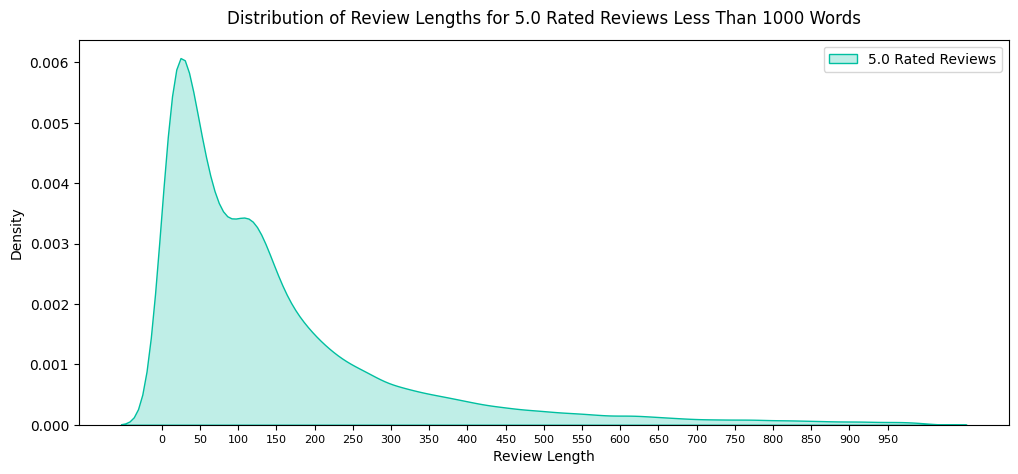

In [17]:
#   Plotting a distribution plot of the review lengths for the five-star rated reviews that are less than 1000 words.

plt.figure(figsize=(12, 5))
sns.distplot(five_star_reviews_subset["reviewText"].str.len(), color="#00BFA0", label="5.0 Rated Reviews", hist=False, kde_kws={"shade": True}, axlabel="Review Length")
plt.title("Distribution of Review Lengths for 5.0 Rated Reviews Less Than 1000 Words", y=1.02)
plt.xticks(np.arange(0, 1000, 50), fontsize=8)
plt.legend(loc="upper right")
plt.show()

The distribution of 5.0 rated reviews appears to conform to a typical pattern expected from genuine customer feedback. Although a significant proportion of the reviews are relatively shorter in length, they still cluster around 50 words, which is consistent with authentic reviews. Conversely, fake reviews are often brief and may only consist of a few words.

Nonetheless, our inference can only be considered valid if the other product ratings also exhibit a similar distribution, thus ensuring the consistency of our findings across all reviews.

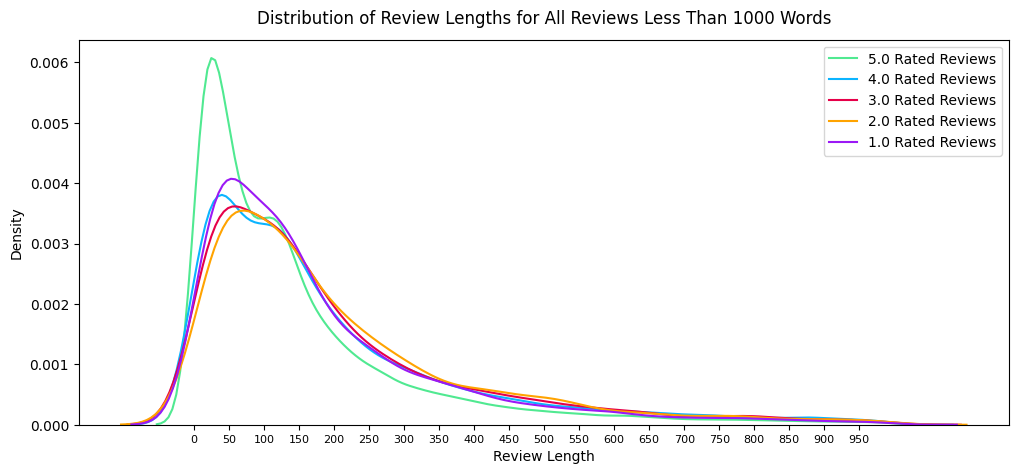

In [18]:
#   Selecting the reviews for each rating that are less than 1000 words.

four_star_reviews=dataframe[dataframe["overall"]==4.0]
three_star_reviews=dataframe[dataframe["overall"]==3.0]
two_star_reviews=dataframe[dataframe["overall"]==2.0]
one_star_reviews=dataframe[dataframe["overall"]==1.0]
four_star_reviews_subset=four_star_reviews[four_star_reviews["reviewText"].str.len()<1000]
three_star_reviews_subset=three_star_reviews[three_star_reviews["reviewText"].str.len()<1000]
two_star_reviews_subset=two_star_reviews[two_star_reviews["reviewText"].str.len()<1000]
one_star_reviews_subset=one_star_reviews[one_star_reviews["reviewText"].str.len()<1000]

#   Plotting a combined distribution plot of the review lengths for each rating of reviews that are less than 1000 words.

plt.figure(figsize=(12, 5))
sns.distplot(five_star_reviews_subset["reviewText"].str.len(), color="#50E991", label="5.0 Rated Reviews", hist=False, axlabel="Review Length")
sns.distplot(four_star_reviews_subset["reviewText"].str.len(), color="#0BB4FF", label="4.0 Rated Reviews", hist=False, axlabel="Review Length")
sns.distplot(three_star_reviews_subset["reviewText"].str.len(), color="#E60049", label="3.0 Rated Reviews", hist=False, axlabel="Review Length")
sns.distplot(two_star_reviews_subset["reviewText"].str.len(), color="#FFA300", label="2.0 Rated Reviews", hist=False, axlabel="Review Length")
sns.distplot(one_star_reviews_subset["reviewText"].str.len(), color="#9B19F5", label="1.0 Rated Reviews", hist=False, axlabel="Review Length")
plt.title("Distribution of Review Lengths for All Reviews Less Than 1000 Words", y=1.02)
plt.xticks(np.arange(0, 1000, 50), fontsize=8)
plt.legend(loc="upper right")
plt.show()

Upon examining the distributions of product ratings in relation to review lengths, we observe striking similarities across all ratings. This suggests that the majority of reviews are likely to comprise authentic customer feedback, with only minor exceptions. Consequently, we can reasonably infer that our conclusion holds true.

To ensure the reliability of our findings, it is necessary to investigate the possibility of fake reviews in the dataset. We can accomplish this by examining factors such as review text, review timing, and review verification status to detect any potential correlations that may indicate the presence of fake reviews.

In [19]:
five_star_reviews[five_star_reviews.duplicated(subset=["asin", "reviewText"], keep=False)].sort_values(by=["asin", "reviewText"])   #   Finding any duplicate five-star reviews for the same product.

,asin,image,overall,reviewText,reviewerID,reviewerName,summary,reviewTime,verified,Color Name,...,Package Type,Pattern,Platform,Product Packaging,Size Name,Size,Style Name,Style,Team Name,Width
67353,038568231X,None,5.0,Great,A14JDYW5GLJUO6,Yvonne F. Breaux,Five Stars,2015-04-22 00:00:00,True,None,...,None,None,None,None,None,None,None,None,None,None
88541,038568231X,None,5.0,Great,A2BT5Y1MWVQZUU,Carolina,Five Stars,2016-03-03 00:00:00,True,None,...,None,None,None,None,None,None,None,None,None,None
40835,B0017O9JG4,None,5.0,HAPPY,A313HY50VE3XW2,STEVE ANDERSON,Five Stars,2016-03-02 00:00:00,True,None,...,None,None,None,None,None,None,None,None,None,None
49181,B0017O9JG4,None,5.0,HAPPY,A313HY50VE3XW2,STEVE ANDERSON,Five Stars,2016-03-02 00:00:00,True,None,...,None,None,None,None,None,None,None,None,None,None
30172,B00MQSMDYU,None,5.0,Works great!,A2B1CHQLY5X21T,Amazon Customer,Five Stars,2017-02-09 00:00:00,True,None,...,None,None,None,None,None,None,None,None,None,None
53523,B00MQSMDYU,None,5.0,Works great!,A2W2ZBHASTM8AY,Kenny S,Five Stars,2017-07-24 00:00:00,True,None,...,None,None,None,None,None,None,None,None,None,None


It should be highlighted that a subset of reviews in the dataset display uniformity in their textual content and summary for a particular product, and are also characterised by their brevity and lack of specificity. Adding to the suspicious nature of these reviews, they were posted at the same time, albeit several months apart, by different verified reviewers. While these reviews may raise doubts about their authenticity, a thorough investigation is required to validate their veracity as fake reviews. Furthermore, there are instances where a verified reviewer submits multiple reviews for the same product, which could indicate the presence of spam in the customer reviews.

In [20]:
majority_review_time=five_star_reviews["reviewTime"].value_counts() #   Aggregating the number of five-star reviews for each date.
majority_review_time=majority_review_time.sort_index()  #   Sorting the number of five-star reviews by date.
figure=go.Figure()  #   Creating an instance of the Figure object.

#   Plotting a line chart of the change in the number of five-star reviews over time.

figure.add_trace(go.Scatter(x=majority_review_time.index, y=majority_review_time.values, mode="lines", name="lines", line=dict(color="#00BFA0", width=2), fill="tozeroy", fillcolor="rgba(0, 191, 160, 0.2)"))
figure.update_layout(title="Change in 5.0 Rated Reviews Over Time", xaxis_title="Date", yaxis_title="Number of Reviews")
figure.show()

Analysing the trend of the number of 5.0 rated reviews over time, we find no substantial increase or spike that would indicate the presence of spam reviews. Instead, the number of reviews has consistently increased over the entire period of the dataset, which is not surprising given Amazon.com's growing popularity over the years.

It is worth noting that there appears to be a slight decrease in the trend of the number of 5.0 rated reviews towards the end of the dataset, around the end of 2018. Although it is not possible to make definitive conclusions based on the sample data, this could suggest a potential decline in customer satisfaction. However, other factors could also have contributed to this trend, and further investigation would be required to confirm this.

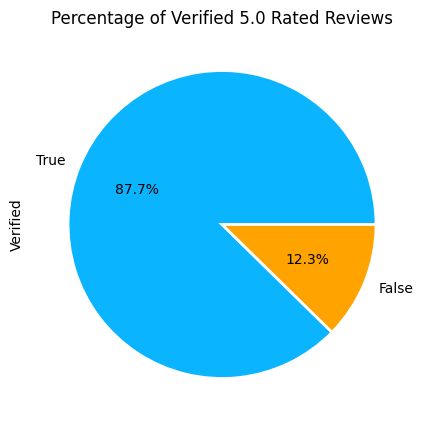

In [21]:
verification_status=five_star_reviews["verified"].value_counts()    #   Aggregating the number of verified and unverified five-star reviews.

#   Plotting a pie chart of the percentage of verified and unverified five-star reviews.

verification_status.plot.pie(autopct="%1.1f%%", figsize=(5, 5), colors=["#0BB4FF", "#FFA300"], title="Percentage of Verified 5.0 Rated Reviews", fontsize=10, wedgeprops={"linewidth": 2, "edgecolor": "white"})
plt.ylabel("Verified")
plt.show()

It appears that a large proportion of the 5.0 rated reviews have been verified by Amazon.com. While this alone may not be conclusive evidence for determining the authenticity of the reviews, as we have previously established that some verified reviews could still be fake, it does lend support to the idea that the majority of the reviews likely reflect genuine customer feedback.

##### **Conclusion:**

Although there is some indication that automated bots may have produced some fake reviews in the dataset, such instances are statistically insignificant and do not seem to represent a significant portion of the total reviews. Additionally, the dataset shows signs of spam reviews, which could either be a technical error or the result of customers or automated bots submitting numerous reviews for the same product.

##### **• Is there a correlation between the length of reviews and the ratings they receive?**

As we delve deeper into our review text analysis, a compelling hypothesis arises; whether there exists a correlation between the length of a review and the rating assigned by the customer. The notion is that longer reviews may indicate higher customer satisfaction as customers are more inclined to share their thoughts in detail. To investigate this hypothesis, we can examine whether there is a noticeable pattern or correlation between the length of reviews and the ratings they receive.

In [22]:
dataframe["Review_Length"]=dataframe["reviewText"].str.len()    #   Creating a new column for the length of the review.
print("Correlation Between Review Length and Rating:", dataframe["Review_Length"].corr(dataframe["overall"]))   #   Calculating the correlation between the length of the review and the rating.

Correlation Between Review Length and Rating: -0.05341014175648146


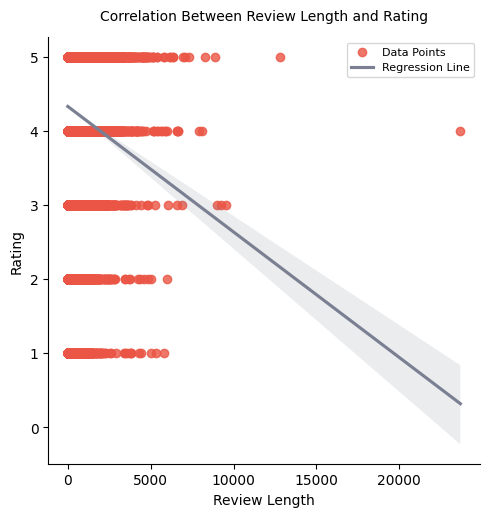

In [23]:
#   Plotting a scatter plot of the review length and the rating, with a regression line.

sns.lmplot(x="Review_Length", y="overall", data=dataframe, height=5, scatter_kws={"color": "#EA5545"}, line_kws={"color": "#7A8092"})
plt.title("Correlation Between Review Length and Rating", y=1.02, fontsize=10)
plt.xlabel("Review Length")
plt.ylabel("Rating")
plt.legend(["Data Points", "Regression Line"], loc="upper right", fontsize=8)
plt.show()

Our analysis shows a weak negative correlation between the length of reviews and their ratings, suggesting that as the length of reviews increases, the ratings they receive tend to decrease. One potential explanation for this trend could be that customers are more likely to write longer reviews as complaints when they are dissatisfied with a product. However, to determine whether this correlation is statistically significant, we need to perform a hypothesis test.

One way to test the significance of the correlation coefficient is to calculate the p-value, which indicates the probability of observing such a strong correlation by chance alone. Statistically, a p-value less than 0.05 is generally considered significant, meaning that the correlation of approximately -0.053 is unlikely to be due to random chance. To calculate the p-value, we can use a significance test with the null hypothesis that the true correlation coefficient is zero.

$$H_0 : ρ = 0$$
$$H_a : ρ ≠ 0$$

In [24]:
print("P-Value:", stats.pearsonr(dataframe["Review_Length"], dataframe["overall"])[1])  #   Calculating the p-value for the null hypothesis that the true correlation coefficient is zero.

P-Value: 5.0951486273933535e-64


##### **Conclusion:**

The p-value we have calculated is well below 0.05, indicating that the correlation coefficient we have observed is highly statistically significant. This means that the likelihood of such a strong correlation occurring by chance alone is very low. As a result, we can reject the null hypothesis that the true correlation coefficient is zero and conclude that there is indeed a significant correlation between review length and rating.

##### **• Is there a significant difference in the mean rating received between verified and non-verified reviewers?**

It is reasonable to propose that there is a notable distinction in the ratings received between verified and non-verified reviewers. If such a difference exists, it could have significant implications for comprehending how customers perceive and assess products on Amazon.com. One way to investigate the potential difference in ratings received between verified and non-verified reviewers is by performing a hypothesis test using the t-test. This approach can help us determine whether any observed differences are statistically significant or if they are likely due to chance. If the results of the t-test suggest a significant difference in mean ratings between the two groups, we can infer that the difference is unlikely to have occurred by chance. In contrast, if the t-test shows no significant difference in mean ratings, we can conclude that any differences observed are likely due to chance.

In [25]:
verified_reviews=dataframe[dataframe["verified"]=="True"]   #   Selecting the verified reviews.
unverified_reviews=dataframe[dataframe["verified"]=="False"]    #   Selecting the unverified reviews.

It is crucial to acknowledge that the t-test we will perform to compare the mean rating received by verified and non-verified reviewers assumes that the data follows a normal distribution and that the variances of the two groups are not equal. However, if these assumptions are not satisfied, the t-test's results may not be trustworthy. As we have already established that the data follows a normal distribution, we need to verify whether the variances of the two groups are not equal. To do this, we can use Levene's test, which is an inferential statistic used to assess the equality of variances for a variable calculated for two or more groups. In our case, we will assume the null hypothesis that the variances of the verified and unverified reviews are equal.

$$H_0 : σ²_{verified} = σ²_{unverified}$$
$$H_a : σ²_{verified} ≠ σ²_{unverified}$$

In [26]:
print("P-Value (Levene's Test):", stats.levene(verified_reviews["overall"], unverified_reviews["overall"])[1])  #   Calculating the p-value for the null hypothesis that the variances of the verified and unverified reviews are equal.

P-Value (Levene's Test): 7.322839031277801e-07


As the p-value obtained from Levene's test is less than 0.05, we reject the null hypothesis and infer that the variance of the verified and unverified reviews are unequal. Therefore, we can proceed with the t-test to compare the mean ratings received by the two groups.

In this case, our null hypothesis for this hypothesis test is that there is no significant difference in the mean rating received between verified and non-verified reviewers. In other words, the mean rating received by verified reviewers is equal to the mean rating received by non-verified reviewers. The alternate hypothesis, on the other hand, is that there is a significant difference in the mean rating received between verified and non-verified reviewers. Specifically, the mean rating received by verified reviewers is not equal to the mean rating received by non-verified reviewers.

$$H_0 : μ_{verified} = μ_{unverified}$$
$$H_a : μ_{verified} ≠ μ_{unverified}$$

In [27]:
print("Mean Rating for Verified Reviews:", verified_reviews["overall"].mean())  #   Calculating the mean rating for the verified reviews.
print("Mean Rating for Unverified Reviews:", unverified_reviews["overall"].mean())  #   Calculating the mean rating for the unverified reviews.
print("P-Value (T-Test):", stats.ttest_ind(verified_reviews["overall"], unverified_reviews["overall"], equal_var=False)[1]) #   Calculating the p-value for the null hypothesis that there is no significant difference in the mean rating received between verified and non-verified reviewers.

Mean Rating for Verified Reviews: 4.299001406794123
Mean Rating for Unverified Reviews: 4.243850592165199
P-Value (T-Test): 7.063695093882651e-07


##### **Conclusion:**

Since the p-value obtained from the t-test is below 0.05, we reject the null hypothesis that there is no significant difference in the mean rating received between verified and non-verified reviewers and conclude that there is a significant difference in the mean rating received between verified and non-verified reviewers. In practical terms, this suggests that there may be a difference in the way verified and non-verified reviewers perceive and evaluate products on Amazon.com. For example, if verified reviewers consistently rate products higher than non-verified reviewers, this may suggest that verified reviewers have more confidence in the authenticity and quality of the products they are reviewing. On the other hand, if non-verified reviewers consistently rate products lower than verified reviewers, this may suggest that they are more skeptical or critical of the products they review.

##### **• Can we observe any correlation between the number of reviews a reviewer has submitted and the ratings they receive?**

Research reveals that nearly three in four consumers have written an online review for a local business within the last year. Intriguingly, a higher number of people seem to write reviews after positive experiences, with 34% reporting that they only leave online reviews for favorable encounters, while only 7% indicate that they do so exclusively for negative experiences. **(BrightLocal, 2022)**

Given that customers tend to write more reviews for positive experiences than negative ones, it is logical to consider the possibility of a correlation between the number of reviews written and the ratings given. However, can this hypothesis be substantiated by data? To investigate this correlation, we will begin by consolidating reviews from each reviewer. It is important to note that in this process, we will assume that every unique reviewer identification number in the dataset represents a distinct individual, as there may be anonymous reviewers who are assigned a new identification number for each review, despite being the same customer.

In [28]:
reviewer_counts=dataframe["reviewerID"].value_counts()  #   Aggregating the number of reviews for each reviewer in the pandas.DataFrame.
reviewer_counts=reviewer_counts.to_frame().reset_index()    #   Converting the reviewer counts to a pandas.DataFrame.
reviewer_counts.columns=["reviewerID", "Review_Count"]  #   Renaming the columns of the pandas.DataFrame.
reviewer_counts=reviewer_counts.merge(dataframe[["reviewerID", "overall"]], on="reviewerID", how="left")    #   Merging the reviewer counts with the product ratings in the pandas.DataFrame.
reviewer_counts=reviewer_counts.drop_duplicates(subset=["reviewerID"])  #   Dropping any duplicate reviewer identification numbers in the pandas.DataFrame.
reviewer_counts=reviewer_counts.sort_values(by="overall", ascending=False)  #   Sorting the pandas.DataFrame by the overall rating.
reviewer_counts=reviewer_counts.reset_index(drop=True)  #   Resetting the index of the pandas.DataFrame.
reviewer_counts

,reviewerID,Review_Count,overall
0,A3LOYXQBDCB2SW,1,5.0
1,A24381CK95OVC4,1,5.0
2,A3QUM1RG1H0TZD,1,5.0
3,A2OGCL3WMDS4Z,1,5.0
4,A28GSXMDVECY9D,1,5.0
...,...,...,...
98913,ATVQTZBOBQ5XC,1,1.0
98914,A3LCILREOKQ4K2,1,1.0
98915,AXRE4JHIISQ11,1,1.0
98916,A20GRS87J0T9JE,1,1.0


In [29]:
print("Correlation Between Number of Reviews and Rating:", reviewer_counts["Review_Count"].corr(reviewer_counts["overall"]))    #   Calculating the correlation between the number of reviews and the rating.

Correlation Between Number of Reviews and Rating: 0.009457167256113003


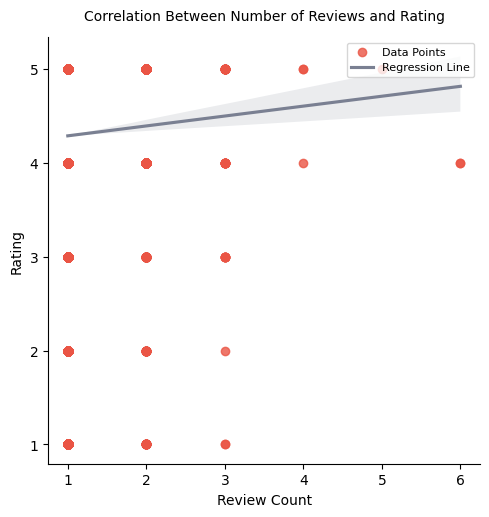

In [30]:
#   Plotting a scatter plot of the number of reviews and the rating, with a regression line.

sns.lmplot(x="Review_Count", y="overall", data=reviewer_counts, height=5, scatter_kws={"color": "#EA5545"}, line_kws={"color": "#7A8092"})
plt.title("Correlation Between Number of Reviews and Rating", y=1.02, fontsize=10)
plt.xlabel("Review Count")
plt.ylabel("Rating")
plt.legend(["Data Points", "Regression Line"], loc="upper right", fontsize=8)
plt.show()

After conducting our analysis, we have observe a weak positive correlation between the number of reviews written by customers and the ratings they assign. Consequently, it may be concluded that as the number of reviews increases, customers are more likely to give higher ratings to other products within the storefront. One plausible explanation for this phenomenon could be that customers become more discerning with each experience and consequently make more informed purchasing decisions.

However, a correlation coefficient of approximately 0.0095 is too weak to establish a significant relationship between the two variables. Therefore, to determine the statistical significance of this correlation, it is imperative that we conduct a hypothesis test. In this case, we will proceed by assuming the null hypothesis that the true correlation coefficient is zero, and then calculate the corresponding p-value.

$$H_0 : ρ = 0$$
$$H_a : ρ ≠ 0$$

In [31]:
print("P-Value:", stats.pearsonr(reviewer_counts["Review_Count"], reviewer_counts["overall"])[1])   #   Calculating the p-value for the null hypothesis that the true correlation coefficient is zero.

P-Value: 0.002935386391740481


##### **Conclusion:**

We have computed a p-value that is below the significance level of 0.05, which indicates that the observed correlation coefficient is highly statistically significant. This implies that the probability of obtaining such a strong correlation by chance alone is very low. Thus, we can reject the null hypothesis, which assumed that the true correlation coefficient is zero, and confidently assert that there is a significant correlation between the number of reviews and the rating assigned by customers.

##### **• Which topics are most commonly referenced in the customer reviews?**

To gain insight into the aspects of products that customers appreciate or criticise, it can be beneficial to pinpoint the most commonly discussed topics in customer reviews. However, it is important to recognise that some topics may be frequently mentioned across all ratings, and identifying these can provide valuable information for product development and marketing strategies.

One approach to identifying the most frequently mentioned topics in customer reviews is to extract key-value pairs from the **reviewText** column, where each key represents a word and the value represents the word's frequency across all reviews of a particular rating. To improve the accuracy of our analysis, we can also eliminate stop words like "the" and "is" which do not add value to our analysis.

In [32]:
#   Function to retrieve all the individual words from a pandas.DataFrame column.

def get_all_words(dataframe, column):
    all_words=[]

    #   Function to add all the words in a review to a list.

    def add_words(review):
        words=review.split(" ") #   Splitting the review into individual words.
        all_words.extend(words) #   Adding the words to the list.
    dataframe[column].apply(add_words)  #   Applying the function to the pandas.DataFrame column.
    return all_words

In [33]:
#   Retrieving all the individual words from all the reviews for each rating.

all_words_five_star_reviews=get_all_words(five_star_reviews, "reviewText")
all_words_four_star_reviews=get_all_words(four_star_reviews, "reviewText")
all_words_three_star_reviews=get_all_words(three_star_reviews, "reviewText")
all_words_two_star_reviews=get_all_words(two_star_reviews, "reviewText")
all_words_one_star_reviews=get_all_words(one_star_reviews, "reviewText")

In [34]:
#   Function to retrieve the word counts for a list of words and convert it to a pandas.DataFrame.

def get_word_counts(all_words):
    word_counts=pd.Series(all_words).value_counts() #   Retrieving the word counts for the list of words.
    word_counts=word_counts.to_frame().reset_index()    #   Converting the word counts to a pandas.DataFrame.
    word_counts.columns=["Word", "Count"]   #   Renaming the columns of the pandas.DataFrame.
    word_counts=word_counts[~word_counts["Word"].isin(stopwords.words("english"))]  #   Removing the stop words from the pandas.DataFrame.
    return word_counts

In [35]:
#   Retrieving the individual word counts for each rating.

word_counts_five_stars=get_word_counts(all_words_five_star_reviews)
word_counts_four_stars=get_word_counts(all_words_four_star_reviews)
word_counts_three_stars=get_word_counts(all_words_three_star_reviews)
word_counts_two_stars=get_word_counts(all_words_two_star_reviews)
word_counts_one_star=get_word_counts(all_words_one_star_reviews)

In [36]:
word_counts_five_stars

,Word,Count
2,I,58596
5,,38789
22,The,11227
24,book,9580
25,great,9560
...,...,...
131355,easily),1
131356,saddle.,1
131357,Buzz!,1
131358,dumber,1


To gain a better insight into the modelling of topics across the reviews, we can utilise a word cloud, which is a visual representation of words used in a particular text or subject, where the size of each word corresponds to its frequency or significance.

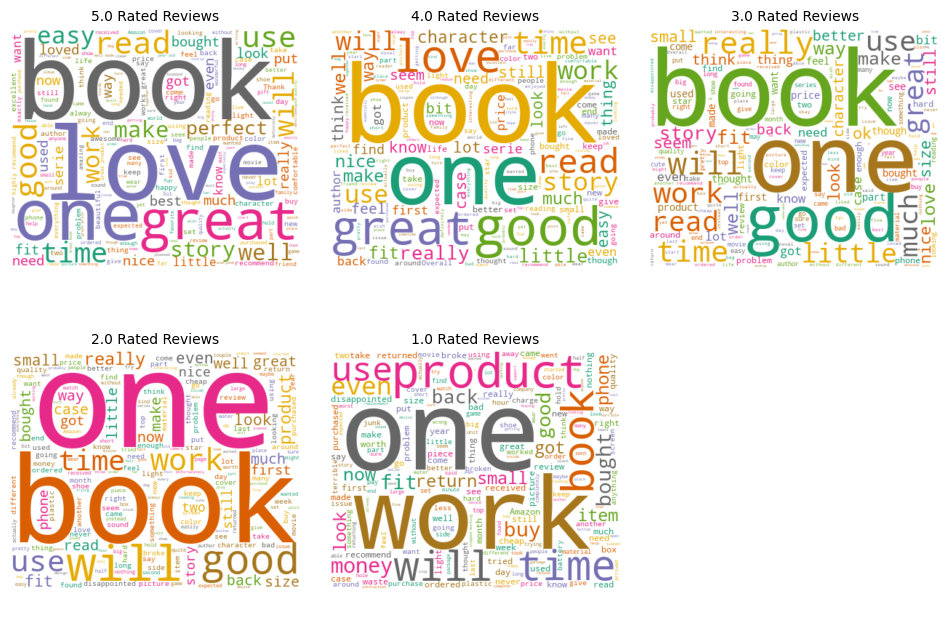

In [37]:
#   Creating a sub-plot for each rating, with the most common words in the reviews for that rating.

figure, axis=plt.subplots(2, 3, figsize=(12, 8))
figure.subplots_adjust(hspace=0.1, wspace=0.1)

#   Plotting the word clouds for all ratings.

wordcloud_five_stars=WordCloud(background_color="white", width=400, height=330, colormap="Dark2").generate(" ".join(all_words_five_star_reviews))
wordcloud_four_stars=WordCloud(background_color="white", width=400, height=330, colormap="Dark2").generate(" ".join(all_words_four_star_reviews))
wordcloud_three_stars=WordCloud(background_color="white", width=400, height=330, colormap="Dark2").generate(" ".join(all_words_three_star_reviews))
wordcloud_two_stars=WordCloud(background_color="white", width=400, height=330, colormap="Dark2").generate(" ".join(all_words_two_star_reviews))
wordcloud_one_star=WordCloud(background_color="white", width=400, height=330, colormap="Dark2").generate(" ".join(all_words_one_star_reviews))
axis[0, 0].imshow(wordcloud_five_stars, interpolation="bilinear")
axis[0, 0].set_title("5.0 Rated Reviews", fontsize=10)
axis[0, 0].axis("off")
axis[0, 1].imshow(wordcloud_four_stars, interpolation="bilinear")
axis[0, 1].set_title("4.0 Rated Reviews", fontsize=10)
axis[0, 1].axis("off")
axis[0, 2].imshow(wordcloud_three_stars, interpolation="bilinear")
axis[0, 2].set_title("3.0 Rated Reviews", fontsize=10)
axis[0, 2].axis("off")
axis[1, 0].imshow(wordcloud_two_stars, interpolation="bilinear")
axis[1, 0].set_title("2.0 Rated Reviews", fontsize=10)
axis[1, 0].axis("off")
axis[1, 1].imshow(wordcloud_one_star, interpolation="bilinear")
axis[1, 1].set_title("1.0 Rated Reviews", fontsize=10)
axis[1, 1].axis("off")
axis[1, 2].axis("off")
plt.show()

##### **Conclusion:**

Based on our analysis, we observe that certain words appear frequently across all ratings, including "love" and "good", which may indicate high customer satisfaction. Interestingly, the word "book" has a notable occurrence across all reviews, suggesting that book purchases may make up a significant portion of the customer demographic. This information may be valuable to Amazon.com in determining where to focus their investments, such as in their book category.

## What Is the Conclusion of Our Exploratory Data Analysis (EDA)?

- Although there are indications that certain reviews in the dataset could be fake or spam, potentially resulting from either identical customers or automated bots, these instances are statistically negligible and constitute only a small fraction of the overall reviews.

- Review length has a statistically significant weak negative correlation with the rating, indicating that longer reviews tend to receive lower ratings.

- There may be differences in the way verified and non-verified reviewers perceive and evaluate products on Amazon.com. If verified reviewers consistently rate products higher than non-verified reviewers, this could indicate that verified reviewers have more confidence in the quality and authenticity of the products they are reviewing.

- There is a statistically significant weak positive correlation between the number of reviews and the rating given by customers, suggesting that as the number of reviews increases, customers tend to give higher ratings to products.

- Our topical analysis suggests that the book category may hold a significant place in the customer demographic, indicating that Amazon.com could benefit from investing in this category.

In [38]:
spark.stop()    #   Stopping the SparkSession instance.